<a href="https://colab.research.google.com/github/MikelBros/LSTM_Tutorial/blob/master/multivariate_multistep_lstm_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# multivariate lstm example
from numpy import array
from numpy import hstack
import numpy as np
from sklearn import metrics
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# We have created a function to print accuracy metrics which can be used
# to get accuracy metrics of all models in upcoming steps
def print_accuracy_report(y_test, y_pred):
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))


# We stacked the data in the example before so we can reuse it. However,
# we need to define a new split function
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		#if len(sequences[i:end_ix, :-1]) <= n_steps_in:
		#	break
		#if len(sequences[end_ix:out_end_ix, -1]) <= n_steps_out:
		#	break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix:out_end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)


# define input sequence
x = np.linspace(0, 2 * np.pi, 100)
raw_seq_a = np.sin(x-0.5)
raw_seq_b = np.sin(x+0.5)
out_seq = array([raw_seq_a[i]+raw_seq_b[i] for i in range(len(raw_seq_a))])

# convert to [rows, columns] structure
raw_seq_a = raw_seq_a.reshape((len(raw_seq_a), 1))
raw_seq_b = raw_seq_b.reshape((len(raw_seq_b), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

# horizontally stack columns
dataset = hstack((raw_seq_a, raw_seq_b, out_seq))

# choose a number of time steps
n_steps_in, n_steps_out = 3, 4
# convert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)

print(raw_seq_a[0:3])
print(raw_seq_b[0:3])
print(out_seq[0:(n_steps_in+n_steps_out)])
print(X.shape, y.shape)
print(X[0], y[0])
print(X[1], y[1])

[[-0.47942554]
 [-0.42280057]
 [-0.36447314]]
[[0.47942554]
 [0.53412003]
 [0.5866638 ]]
[[0.        ]
 [0.11131945]
 [0.22219066]
 [0.33216718]
 [0.44080619]
 [0.54767022]
 [0.65232898]]
(94, 3, 2) (94, 4)
[[-0.47942554  0.47942554]
 [-0.42280057  0.53412003]
 [-0.36447314  0.5866638 ]] [0.33216718 0.44080619 0.54767022 0.65232898]
[[-0.42280057  0.53412003]
 [-0.36447314  0.5866638 ]
 [-0.3046781   0.63684529]] [0.44080619 0.54767022 0.65232898 0.75436104]


In [4]:
# split the sequence in a train and test set
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=42, 
                                                    test_size=0.2,
                                                    shuffle=True)

# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]

# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit(X_train, y_train, epochs=2000, verbose=0)

# check the accuracy of the model
yhat = model.predict(X_test, verbose=0)
print_accuracy_report(y_test, yhat)





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








Mean Absolute Error: 0.003712351100975498


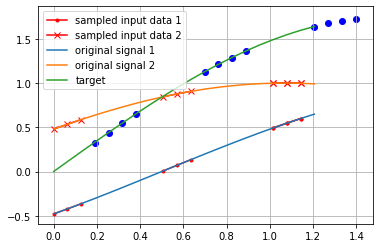

In [5]:
max_ = 20

# demonstrate predictions
for i in range(0, max_, (n_steps_in+n_steps_out+1)):
  # Notice that the training was peformed on data between [0, 2pi)!
  # The model has learned non-linear transform between the shifted sinus 
  # functions to a third sinus wave
  x = np.linspace(0 * np.pi, 2 * np.pi, 100)
  x_t = x[i:i+n_steps_in]
  #print(len(x_t))
  input_a = raw_seq_a[i:i+n_steps_in]
  input_b = raw_seq_b[i:i+n_steps_in]
  input_ = hstack((input_a, input_b))
  plt.plot(x_t, input_a, color='red', marker = '.')
  plt.plot(x_t, input_b, color='red', marker = 'x')
  input_ = input_.reshape((1, n_steps_in, n_features))
  yhat = model.predict(input_, verbose=0)
  #print(yhat[0])
  #print(len(x[i+n_steps_in:i+n_steps_in+4]))
  if len(x[(i+n_steps_in):(i+n_steps_in+n_steps_out)]) == n_steps_out:
    plt.scatter(x[(i+n_steps_in):(i+n_steps_in+n_steps_out)], 
                yhat[0], 
                color='blue')
  else:
    pass
    
  
#plt.scatter(x[i+n_steps_in:i+n_steps_in+4], yhat, color='blue', label='predictions')
plt.plot(x_t, input_a, color='red', marker = '.', label='sampled input data 1')
plt.plot(x_t, input_b, color='red', marker = 'x', label='sampled input data 2')
plt.plot(x[0:max_], raw_seq_a[0:max_], label='original signal 1')
plt.plot(x[0:max_], raw_seq_b[0:max_], label='original signal 2')
plt.plot(x[0:max_], out_seq[0:max_], label='target')

plt.grid()
plt.legend()